<h1 class='font-effect-3d' style='color:firebrick; font-family:Akronim;'>Code Modules, Helpful Functions, Styling, and Links</h1>
[Github Version](https://github.com/OlgaBelitskaya/deep_learning_projects/tree/master/DL_PP5) & [Colaboratory Version](https://colab.research.google.com/drive/1Tt3qZePsf2P6kNNao-hQ58DlG71Abj5a)

In [1]:
%%html
<style> 
@import url('https://fonts.googleapis.com/css?family=Akronim|Roboto&effect=3d');
body {background-color:#f7e8e8;} 
a,h4 {color:crimson; font-family:Roboto;}
span {color:black; text-shadow:4px 4px 4px #aaa;}
div.output_prompt {color:crimson;} 
div.input_prompt {color:firebrick;} 
div.output_area pre,div.output_subarea {font-size:15px; color:crimson}
div.output_stderr pre {background-color:#f7e8e8;}
</style>

In [2]:
import warnings; warnings.filterwarnings('ignore')
import numpy as np,pandas as pd,pylab as pl
import h5py,cv2,tensorflow as tf
from tqdm import tqdm
from skimage import color,measure
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential,load_model,Model
from keras.layers import Input,Activation,Dense,LSTM
from keras.layers import Flatten,Dropout,BatchNormalization
from keras.layers import Conv2D,MaxPooling2D,GlobalMaxPooling2D
from keras.layers.advanced_activations import PReLU,LeakyReLU
from keras import __version__
print('keras version:', __version__)
print('tensorflow version:',tf.__version__)
np.set_printoptions(precision=6)
pl.style.use('seaborn-whitegrid')
fw='weights.decor.hdf5'
n=np.random.choice(484,size=6,replace=False)

Using TensorFlow backend.


keras version: 2.1.5
tensorflow version: 1.7.0


In [3]:
def tts(X,y): 
    x_train,x_test,y_train,y_test=\
    train_test_split(X,y,test_size=.2,random_state=1)
    n=int(len(x_test)/2)
    x_valid,y_valid=x_test[:n],y_test[:n]
    x_test,y_test=x_test[n:],y_test[n:]
    return x_train,x_valid,x_test,y_train,y_valid,y_test
def history_plot(fit_history):
    pl.figure(figsize=(12,10)); pl.subplot(211)
    keys=list(fit_history.history.keys())[0:4]
    pl.plot(fit_history.history[keys[0]],
            color='crimson',label='train')
    pl.plot(fit_history.history[keys[2]],
            color='firebrick',label='valid')
    pl.xlabel("Epochs"); pl.ylabel("Loss")
    pl.legend(); pl.grid()
    pl.title('Loss Function')     
    pl.subplot(212)
    pl.plot(fit_history.history[keys[1]],
            color='crimson',label='train')
    pl.plot(fit_history.history[keys[3]],
            color='firebrick',label='valid')
    pl.xlabel("Epochs"); pl.ylabel("Accuracy")    
    pl.legend(); pl.grid()
    pl.title('Accuracy'); pl.show()

<h1 class='font-effect-3d' style='color:firebrick; font-family:Akronim;'>Data Loading and Exploration</h1>

In [4]:
data=pd.read_csv("../input/decor.csv")
data.iloc[n]

,country_label,country,decor_label,decor,type_label,type,file
437,3,Turkey,5,Iznik,1,product,03_05_2_032.png
410,3,Turkey,5,Iznik,1,product,03_05_2_005.png
74,1,Russia,1,Gzhel,2,product,01_01_2_042.png
112,1,Russia,2,Khokhloma,1,pattern,01_02_1_025.png
334,2,Poland,7,Wzory kaszubskie,1,pattern,02_07_1_004.png
12,1,Russia,1,Gzhel,1,pattern,01_01_1_013.png


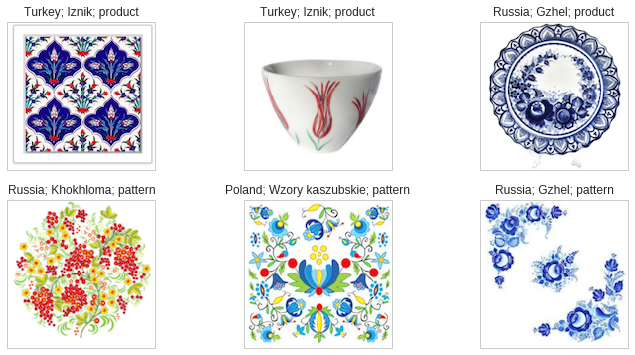

In [5]:
def display_images(img_path,ax):
    img=cv2.imread("../input/decor/"+img_path)
    ax.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))  
fig=pl.figure(figsize=(12,6))
for i in range(6):
    ax=fig.add_subplot(2,3,i+1,xticks=[],yticks=[], 
                       title=data['country'][n[i]]+'; '+\
                       data['decor'][n[i]]+'; '+data['type'][n[i]])
    display_images(data['file'][n[i]],ax)

In [6]:
f=h5py.File('../input/DecorColorImages.h5','r')
keys=list(f.keys())
[countries,decors,images,types]=\
[np.array(f[keys[i]]) for i in range(4)]
images=images/255
cdecors=to_categorical(np.array(decors-1),7)
sh=[el.shape for el in [images,decors,cdecors,
                        countries,types]]
pd.DataFrame(sh)

,0,1,2,3
0,485,150.0,150.0,3.0
1,485,NaN,NaN,NaN
2,485,7.0,NaN,NaN
3,485,NaN,NaN,NaN
4,485,NaN,NaN,NaN


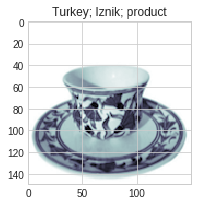

In [7]:
gray_images=np.dot(images[...,:3],[.299,.587,.114])
pl.figure(figsize=(3,3))
n=np.random.choice(484,size=1,replace=False)[0]
pl.imshow(images[n])
pl.title(data['country'][n]+'; '+\
         data['decor'][n]+'; '+data['type'][n])
pl.imshow(gray_images[n],cmap=pl.cm.bone); pl.show()
gray_images=gray_images.reshape(-1,150,150,1)

In [8]:
# Spliting the data 
# Color Images / Decors 
x_train3,x_valid3,x_test3,\
y_train3,y_valid3,y_test3=tts(images,cdecors)
# Grayscaled Images / Decors 
x_train4,x_valid4,x_test4,\
y_train4,y_valid4,y_test4=tts(gray_images,cdecors)
sh=[el.shape for el in \
[x_train3,y_train3,x_valid3,y_valid3,x_test3,y_test3,
 x_train4,y_train4,x_valid4,y_valid4,x_test4,y_test4]]
pd.DataFrame(sh)

,0,1,2,3
0,388,150,150.0,3.0
1,388,7,NaN,NaN
2,48,150,150.0,3.0
3,48,7,NaN,NaN
4,49,150,150.0,3.0
5,49,7,NaN,NaN
6,388,150,150.0,1.0
7,388,7,NaN,NaN
8,48,150,150.0,1.0
9,48,7,NaN,NaN


<h1 class='font-effect-3d' style='color:firebrick; font-family:Akronim;'>Neural Networks for One-Label Classification</h1>

In [9]:
def model(leaky_alpha):
    model=Sequential()
    model.add(Conv2D(32,(5,5),padding='same',
                     input_shape=x_train3.shape[1:]))
    model.add(LeakyReLU(alpha=leaky_alpha))    
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(.25))
    model.add(Conv2D(196,(5,5)))
    model.add(LeakyReLU(alpha=leaky_alpha))    
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(.25))   
    model.add(GlobalMaxPooling2D())     
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=leaky_alpha))
    model.add(Dropout(.25))   
    model.add(Dense(7))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='nadam',metrics=['accuracy'])    
    return model
model=model(.025)

In [10]:
lr_reduction=ReduceLROnPlateau(monitor='val_loss',patience=5,
                               verbose=2,factor=.5)
checkpointer=ModelCheckpoint(filepath=fw,verbose=2,save_best_only=True)
estopping=EarlyStopping(monitor='val_loss',patience=15,verbose=2)
history=model.fit(x_train3,y_train3, 
                  epochs=50,batch_size=16,verbose=2,
                  validation_data=(x_valid3,y_valid3),
                  callbacks=[checkpointer,lr_reduction,estopping])

Train on 388 samples, validate on 48 samples
Epoch 1/50
 - 42s - loss: 1.8102 - acc: 0.3196 - val_loss: 1.5843 - val_acc: 0.2708

Epoch 00001: val_loss improved from inf to 1.58433, saving model to weights.decor.hdf5
Epoch 2/50
 - 41s - loss: 1.4088 - acc: 0.4278 - val_loss: 1.5537 - val_acc: 0.3333

Epoch 00002: val_loss improved from 1.58433 to 1.55369, saving model to weights.decor.hdf5
Epoch 3/50
 - 41s - loss: 1.1950 - acc: 0.4897 - val_loss: 1.9534 - val_acc: 0.3333

Epoch 00003: val_loss did not improve
Epoch 4/50
 - 41s - loss: 1.1753 - acc: 0.5747 - val_loss: 1.4314 - val_acc: 0.4167

Epoch 00004: val_loss improved from 1.55369 to 1.43145, saving model to weights.decor.hdf5
Epoch 5/50
 - 41s - loss: 0.8758 - acc: 0.6830 - val_loss: 2.4326 - val_acc: 0.2917

Epoch 00005: val_loss did not improve
Epoch 6/50
 - 41s - loss: 1.0982 - acc: 0.6211 - val_loss: 1.0587 - val_acc: 0.5000

Epoch 00006: val_loss improved from 1.43145 to 1.05871, saving model to weights.decor.hdf5
Epoch 7/5

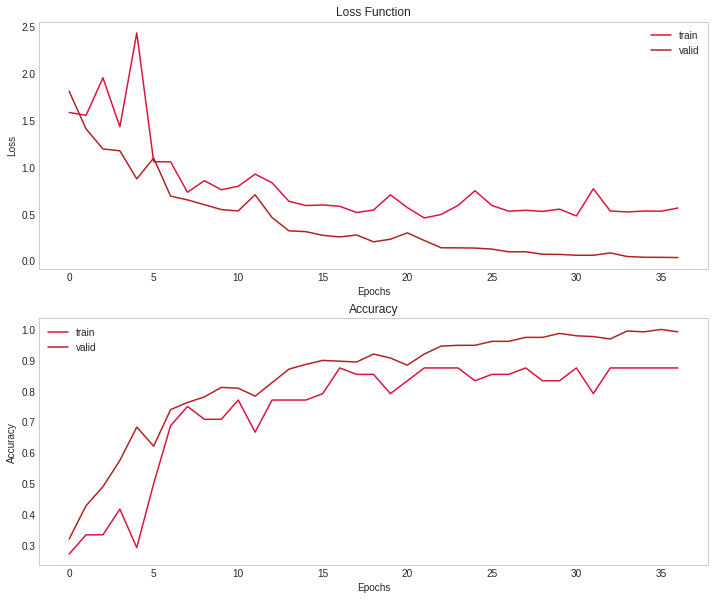

49/49 [==============================] - 2s 35ms/step


[0.5010211674534545, 0.8367346987432364]

In [11]:
history_plot(history)
model.load_weights(fw)
model.evaluate(x_test3,y_test3)

In [12]:
steps,epochs=100,10
generator=ImageDataGenerator(zoom_range=.3,shear_range=.3,
                             rotation_range=30,
                             horizontal_flip=True,vertical_flip=True)
history=model.fit_generator(generator.flow(x_train3,y_train3,batch_size=16),
                            steps_per_epoch=steps,epochs=epochs,verbose=2,
                            validation_data=(x_valid3,y_valid3,), 
                            callbacks=[checkpointer,lr_reduction])

Epoch 1/10
 - 166s - loss: 0.2161 - acc: 0.9194 - val_loss: 0.5014 - val_acc: 0.8750

Epoch 00001: val_loss did not improve
Epoch 2/10
 - 165s - loss: 0.2012 - acc: 0.9300 - val_loss: 0.5103 - val_acc: 0.8750

Epoch 00002: val_loss did not improve
Epoch 3/10
 - 165s - loss: 0.1974 - acc: 0.9250 - val_loss: 0.5024 - val_acc: 0.8542

Epoch 00003: val_loss did not improve
Epoch 4/10
 - 165s - loss: 0.1710 - acc: 0.9356 - val_loss: 0.5017 - val_acc: 0.8542

Epoch 00004: val_loss did not improve
Epoch 5/10
 - 164s - loss: 0.1776 - acc: 0.9394 - val_loss: 0.4886 - val_acc: 0.8750

Epoch 00005: val_loss did not improve
Epoch 6/10
 - 164s - loss: 0.1505 - acc: 0.9463 - val_loss: 0.5077 - val_acc: 0.8542

Epoch 00006: val_loss did not improve
Epoch 7/10
 - 165s - loss: 0.1483 - acc: 0.9419 - val_loss: 0.4908 - val_acc: 0.8542

Epoch 00007: val_loss did not improve
Epoch 8/10
 - 165s - loss: 0.1517 - acc: 0.9463 - val_loss: 0.4908 - val_acc: 0.8750

Epoch 00008: val_loss did not improve
Epoch 9/

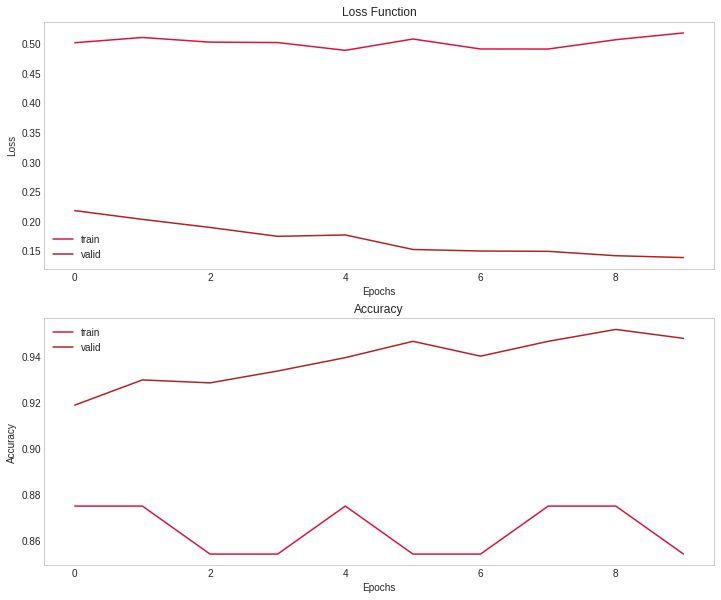

49/49 [==============================] - 2s 34ms/step


[0.5010211674534545, 0.8367346987432364]

In [13]:
history_plot(history)
model.load_weights(fw)
model.evaluate(x_test3,y_test3)

In [14]:
def gray_model(leaky_alpha):
    model=Sequential()
    model.add(Conv2D(32,(5,5),padding='same',
                     input_shape=x_train4.shape[1:]))
    model.add(LeakyReLU(alpha=leaky_alpha))    
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(.25))
    model.add(Conv2D(196,(5,5)))
    model.add(LeakyReLU(alpha=leaky_alpha))    
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(.25))    
    model.add(GlobalMaxPooling2D())     
    model.add(Dense(1024,activation='tanh'))
    model.add(Dropout(.25))   
    model.add(Dense(7))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    return model
gray_model=gray_model(.025)

In [15]:
lr_reduction=ReduceLROnPlateau(monitor='val_loss',patience=5,
                               verbose=2,factor=.7)
checkpointer=ModelCheckpoint(filepath=fw,verbose=2,save_best_only=True)
estopping=EarlyStopping(monitor='val_loss',patience=15,verbose=2)
history=gray_model.fit(x_train4,y_train4, 
                       epochs=50,batch_size=16,verbose=2,
                       validation_data=(x_valid4,y_valid4),
                       callbacks=[checkpointer,lr_reduction,estopping])

Train on 388 samples, validate on 48 samples
Epoch 1/50
 - 39s - loss: 1.9629 - acc: 0.1959 - val_loss: 1.9274 - val_acc: 0.1875

Epoch 00001: val_loss improved from inf to 1.92739, saving model to weights.decor.hdf5
Epoch 2/50
 - 38s - loss: 1.8813 - acc: 0.1675 - val_loss: 1.8989 - val_acc: 0.1875

Epoch 00002: val_loss improved from 1.92739 to 1.89886, saving model to weights.decor.hdf5
Epoch 3/50
 - 38s - loss: 1.8651 - acc: 0.1985 - val_loss: 1.8994 - val_acc: 0.1667

Epoch 00003: val_loss did not improve
Epoch 4/50
 - 38s - loss: 1.7908 - acc: 0.2680 - val_loss: 1.8900 - val_acc: 0.2083

Epoch 00004: val_loss improved from 1.89886 to 1.88999, saving model to weights.decor.hdf5
Epoch 5/50
 - 37s - loss: 1.7643 - acc: 0.2912 - val_loss: 1.9347 - val_acc: 0.1875

Epoch 00005: val_loss did not improve
Epoch 6/50
 - 38s - loss: 1.7217 - acc: 0.2990 - val_loss: 1.8794 - val_acc: 0.2917

Epoch 00006: val_loss improved from 1.88999 to 1.87943, saving model to weights.decor.hdf5
Epoch 7/5

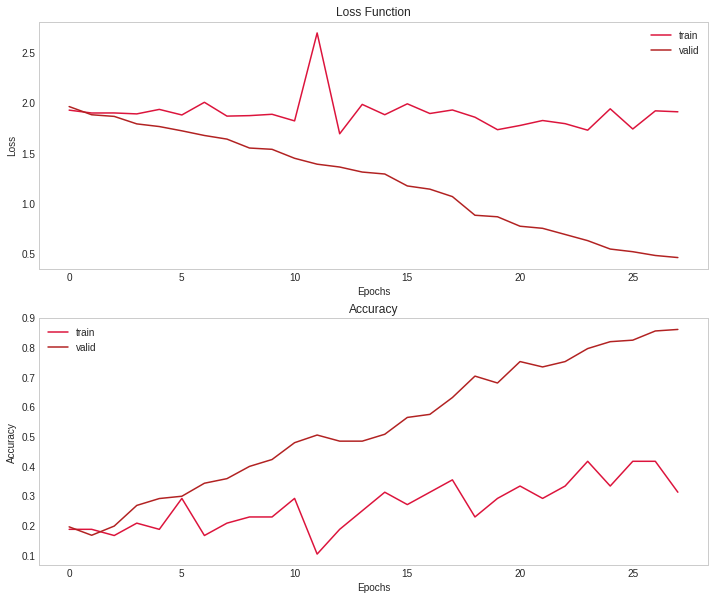

49/49 [==============================] - 1s 29ms/step


[1.7167991862005116, 0.30612245323706644]

In [16]:
history_plot(history)
gray_model.load_weights(fw)
gray_model.evaluate(x_test4,y_test4)